### Importando as bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from warnings import simplefilter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_validate
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.regressor import prediction_error
from yellowbrick.regressor import residuals_plot
simplefilter(action='ignore', category=(FutureWarning, UserWarning))

### Explorando os dados

In [2]:
# Carregando os dados
dados = pd.read_csv('Dados\\flights.csv')
dados.head()

,flight_id,airline,aircraft_type,schengen,origin,arrival_time,departure_time,day,year,is_holiday,delay
0,26,MM,Airbus A320,non-schengen,TCY,8.885071,10.885071,0,2010,False,70.205981
1,10,YE,Airbus A320,non-schengen,TCY,8.939996,11.939996,0,2010,False,38.484609
2,3,BZ,Embraer E175,schengen,TZF,18.635384,22.635384,0,2010,False,2.388305
3,28,BZ,Airbus A330,non-schengen,EMM,15.967963,17.967963,0,2010,False,19.138491
4,15,BZ,Airbus A330,non-schengen,FJB,16.571894,19.571894,0,2010,False,15.016271


In [3]:
# Verificando o tamanho do dataset
print(f'Linhas: {dados.shape[0]} | Colunas: {dados.shape[1]}')

Linhas: 71175 | Colunas: 11


In [4]:
# Verificando os tipos de dados
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71175 entries, 0 to 71174
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   flight_id       71175 non-null  int64  
 1   airline         71175 non-null  object 
 2   aircraft_type   71175 non-null  object 
 3   schengen        71175 non-null  object 
 4   origin          71175 non-null  object 
 5   arrival_time    71175 non-null  float64
 6   departure_time  71175 non-null  float64
 7   day             71175 non-null  int64  
 8   year            71175 non-null  int64  
 9   is_holiday      71175 non-null  bool   
 10  delay           71175 non-null  float64
dtypes: bool(1), float64(3), int64(3), object(4)
memory usage: 5.5+ MB


In [5]:
# Verificando as informações estatísticas das colunas numéricas.
dados.describe()

,flight_id,arrival_time,departure_time,day,year,delay
count,71175.000000,71175.000000,71175.000000,71175.000000,71175.000000,71175.000000
mean,15.465135,13.283159,16.480222,182.000000,2016.000000,12.548378
std,8.649646,4.023380,4.143705,105.366769,3.741684,23.125349
min,1.000000,7.065594,10.065594,0.000000,2010.000000,-41.028033
25%,8.000000,8.939996,12.668655,91.000000,2013.000000,-4.412876
50%,15.000000,14.258911,16.376052,182.000000,2016.000000,9.740454
75%,23.000000,16.909690,20.041281,273.000000,2019.000000,27.650853
max,30.000000,19.341235,23.341235,364.000000,2022.000000,125.632352


In [6]:
# Verificando as informações das colunas categóricas.
dados.describe(include=['O'])

,airline,aircraft_type,schengen,origin
count,71175,71175,71175,71175
unique,3,6,2,10
top,BZ,Airbus A320,schengen,TZF
freq,47598,30778,42569,14162


### Análises Gráficas dos dados

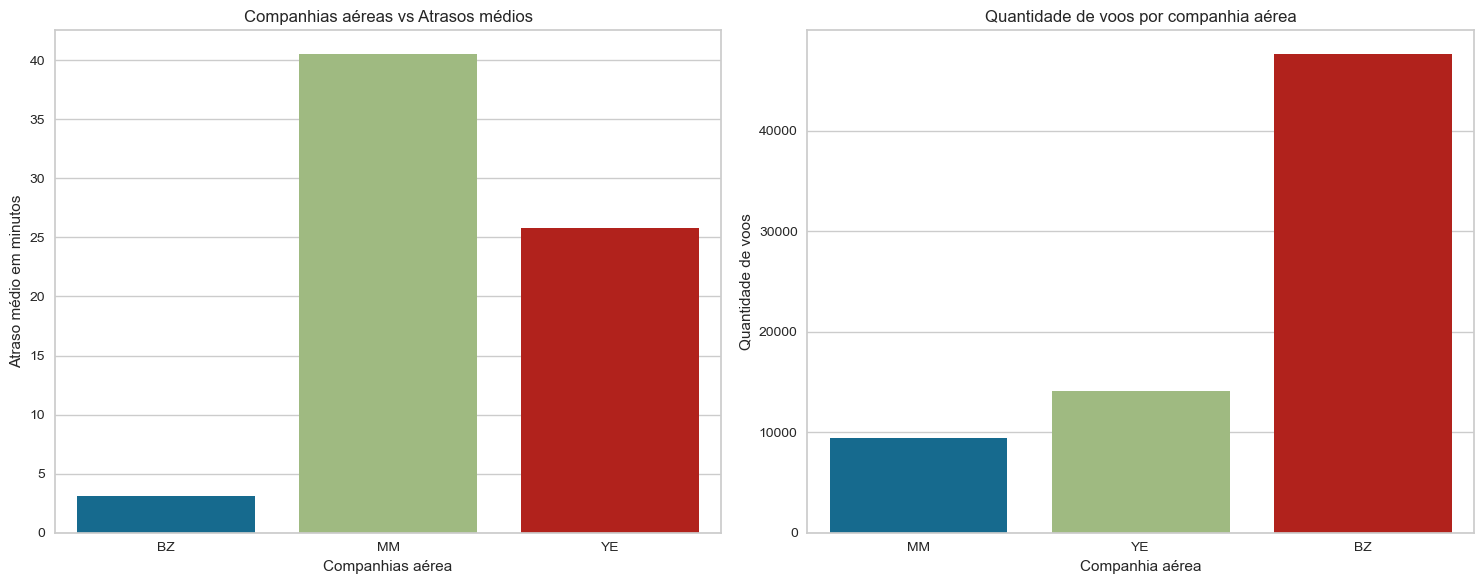

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

average_delay = dados.groupby(['airline'])['delay'].mean().reset_index()
ax1 = sns.barplot(x='airline', y='delay', data=average_delay, ax=axes[0])
ax1.set(title='Companhias aéreas vs Atrasos médios', xlabel='Companhias aérea', ylabel='Atraso médio em minutos')

ax2 = sns.countplot(x='airline', data=dados, ax=axes[1])
ax2.set(title='Quantidade de voos por companhia aérea', xlabel='Companhia aérea', ylabel='Quantidade de voos')

plt.tight_layout()
plt.show()

Nos gráficos apresentados, um interessante padrão se revela: a Companhia MM, apesar de operar menos voos, destaca-se pelo tempo médio de atraso mais longo entre todas as companhias. Enquanto isso, a Companhia BZ lidera em número de voos, porém surpreende com um tempo médio de atraso incrivelmente curto. Já a Companhia YE se posiciona em um ponto intermediário, sem alcançar os extremos das outras duas companhias, tanto em quantidade de voos quanto no tempo médio de atraso.

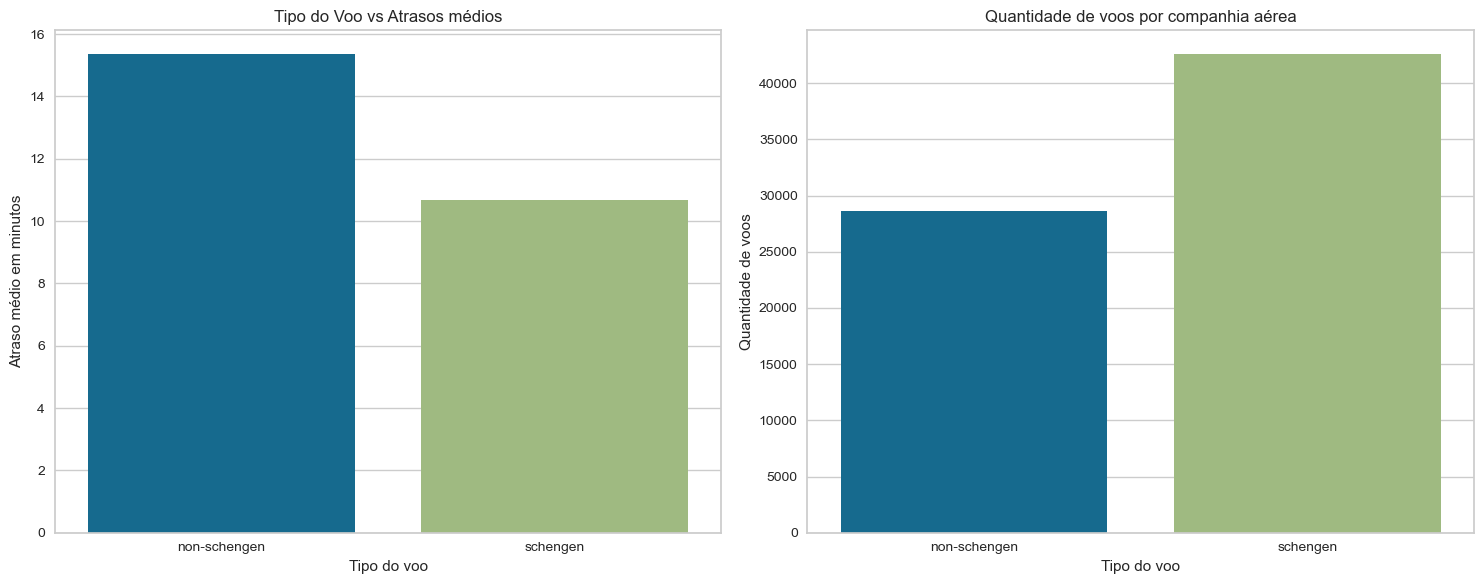

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

average_delay = dados.groupby(['schengen'])['delay'].mean().reset_index()
ax1 = sns.barplot(x='schengen', y='delay', data=average_delay, ax=axes[0])
ax1.set(title='Tipo do Voo vs Atrasos médios', xlabel='Tipo do voo', ylabel='Atraso médio em minutos')

ax2 = sns.countplot(x='schengen', data=dados, ax=axes[1])
ax2.set(title='Quantidade de voos por companhia aérea', xlabel='Tipo do voo', ylabel='Quantidade de voos')

plt.tight_layout()
plt.show()

Observando os gráficos acima, notamos que os voos com destino ao Espaço Schengen predominam, apresentando um tempo médio de atraso em torno de 10 minutos. Por outro lado, os voos para países fora desse acordo têm um tempo médio de atraso superior ao primeiro grupo mencionado, variando em torno de 5 minutos a mais.

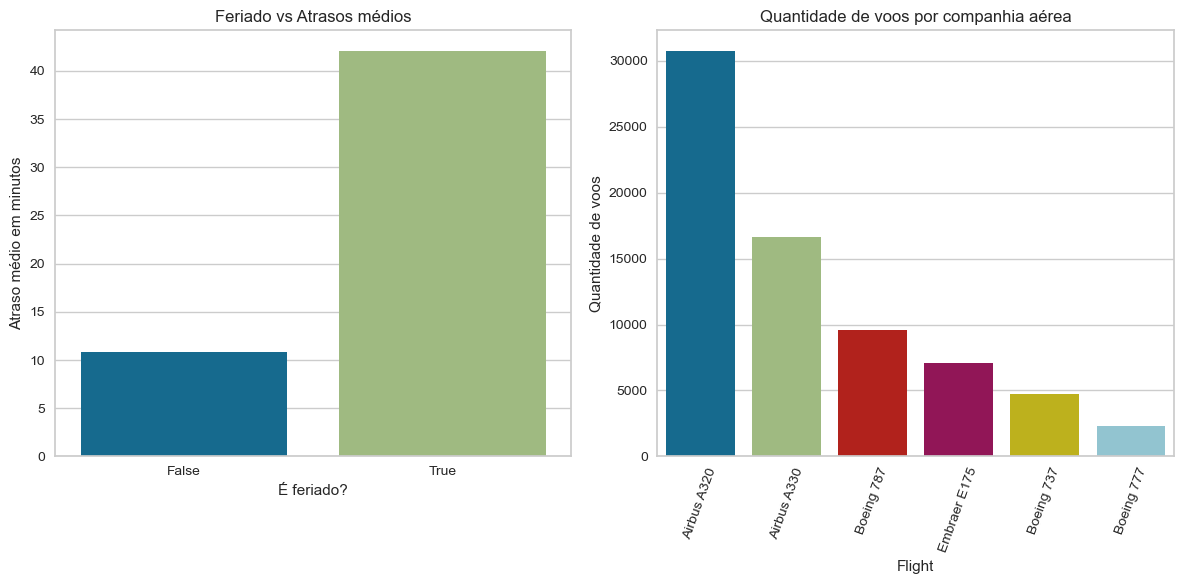

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

average_delay = dados.groupby(['is_holiday'])['delay'].mean().reset_index()
ax1 = sns.barplot(x='is_holiday', y='delay', data=average_delay, ax=axes[0])
ax1.set(title='Feriado vs Atrasos médios', xlabel='É feriado?', ylabel='Atraso médio em minutos')

order = dados['aircraft_type'].value_counts().index
ax2 = sns.countplot(x='aircraft_type', data=dados, order=order, ax=axes[1])
ax2.set(title='Quantidade de voos por companhia aérea', xlabel='Flight', ylabel='Quantidade de voos')
plt.xticks(rotation=70)

plt.tight_layout()
plt.show()

Podemos observar que nos feriados, pelo gráfico à esquerda, há uma incidência maior de atrasos em comparação aos dias úteis. Já no gráfico à direita, chama a atenção que os voos da Airbus estão mais propensos a atrasos quando comparados com outros tipos de voos.

### Análise da distribuição dos dados

In [10]:
def calcular_largura_bin(df, coluna):
    Q75, Q25 = np.percentile(df[coluna],[75,25])
    IQR = Q75 - Q25
    largura_bin = 2 * IQR * np.power(len(df[coluna]), -1/3)
    return largura_bin

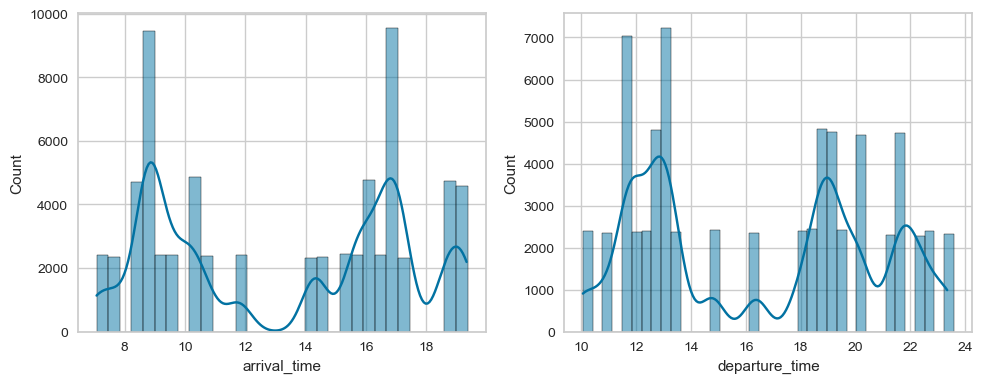

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

largura_bin_at = calcular_largura_bin(dados, 'arrival_time')
ax1 = sns.histplot(data=dados, x='arrival_time', bins=10, kde=True, binwidth=largura_bin_at, ax=axes[0])

largura_bin_dt = calcular_largura_bin(dados, 'departure_time')
ax2 = sns.histplot(data=dados, x='departure_time', bins=10, kde=True, binwidth=largura_bin_dt, ax=axes[1])

plt.tight_layout()
plt.show()

No primeiro histograma a esquerda, podemos observar que são esses os horários em que há mais voos chegando no aeroporto: por volta das 9h e por volta das 17h, com o pico subindo e descendo.

Ao observar o segundo histograma, parece haver um padrão interessante ao redor do meio-dia, onde há um aumento significativo no número de voos, seguido por uma diminuição e, logo após, outro pico. É possível que esses voos do meio-dia estejam conectados aos que chegam por volta das 9 horas, como analisamos anteriormente. Essa relação parece se repetir por volta das 18 e 19 horas. Por exemplo, próximos às 19 horas, é esperado que os voos que chegaram por volta das 17 horas partam nesse horário.

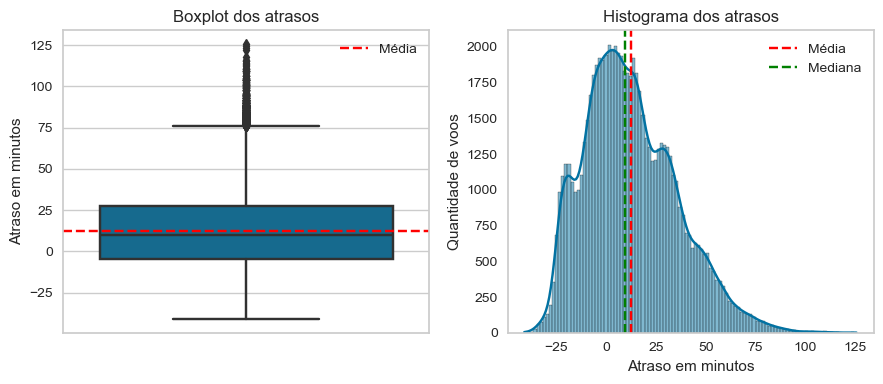

In [12]:
mean_delay = dados['delay'].mean()
median_delay = dados['delay'].median()

fig, axes = plt.subplots(1, 2, figsize=(9, 4))

sns.boxplot(data=dados, y='delay', ax=axes[0])
axes[0].set(title='Boxplot dos atrasos', ylabel='Atraso em minutos')
axes[0].axhline(y=mean_delay, ls='--', color='red', label='Média')
axes[0].legend()

largura_bin_delay = calcular_largura_bin(dados, 'delay')
sns.histplot(data=dados, x='delay', kde=True, ax=axes[1], binwidth=largura_bin_delay)
plt.ylabel('Quantidade de voos')
plt.grid(False)
axes[1].set(title='Histograma dos atrasos', xlabel='Atraso em minutos')
axes[1].axvline(x=mean_delay, ls='--', color='red', label='Média')
axes[1].axvline(x=median_delay, ls='--', color='green', label='Mediana')
axes[1].legend()

plt.tight_layout()
plt.show()

No boxplot gerado, podemos notar que mesmo com outliers, eles não afetam drasticamente a forma do gráfico. Parecem ser possíveis valores atípicos, mas provavelmente representam casos isolados dentro do nosso conjunto de dados, que mantém a média em torno de 15, mais ou menos.

Ao analisar a distribuição da variável alvo, imprimimos a média e a mediana, notando uma leve assimetria à direita. No entanto, essa assimetria não parece comprometer a qualidade dos dados. Era esperado que a distribuição apresentasse essa inclinação, mas surpreendentemente, ela está relativamente próxima da normalidade, sem uma assimetria tão pronunciada para o lado direito.

### Feature Engineering

In [13]:
# Verificando os dados.
dados.head(1)

,flight_id,airline,aircraft_type,schengen,origin,arrival_time,departure_time,day,year,is_holiday,delay
0,26,MM,Airbus A320,non-schengen,TCY,8.885071,10.885071,0,2010,False,70.205981


#### Criando novas colunas

In [14]:
# Criando uma nova coluna data.
dados['date'] = pd.to_datetime(dados['year'].astype(str) + '-' + (dados['day'] + 1).astype(str), format='%Y-%j')
dados.head()

,flight_id,airline,aircraft_type,schengen,origin,arrival_time,departure_time,day,year,is_holiday,delay,date
0,26,MM,Airbus A320,non-schengen,TCY,8.885071,10.885071,0,2010,False,70.205981,2010-01-01
1,10,YE,Airbus A320,non-schengen,TCY,8.939996,11.939996,0,2010,False,38.484609,2010-01-01
2,3,BZ,Embraer E175,schengen,TZF,18.635384,22.635384,0,2010,False,2.388305,2010-01-01
3,28,BZ,Airbus A330,non-schengen,EMM,15.967963,17.967963,0,2010,False,19.138491,2010-01-01
4,15,BZ,Airbus A330,non-schengen,FJB,16.571894,19.571894,0,2010,False,15.016271,2010-01-01


In [15]:
# Criando colunas que indicam se o dia é final de semana ou não.
dados['is_weekend'] = dados['date'].dt.weekday.isin([5, 6])
dados.head()

,flight_id,airline,aircraft_type,schengen,origin,arrival_time,departure_time,day,year,is_holiday,delay,date,is_weekend
0,26,MM,Airbus A320,non-schengen,TCY,8.885071,10.885071,0,2010,False,70.205981,2010-01-01,False
1,10,YE,Airbus A320,non-schengen,TCY,8.939996,11.939996,0,2010,False,38.484609,2010-01-01,False
2,3,BZ,Embraer E175,schengen,TZF,18.635384,22.635384,0,2010,False,2.388305,2010-01-01,False
3,28,BZ,Airbus A330,non-schengen,EMM,15.967963,17.967963,0,2010,False,19.138491,2010-01-01,False
4,15,BZ,Airbus A330,non-schengen,FJB,16.571894,19.571894,0,2010,False,15.016271,2010-01-01,False


In [16]:
# Criando coluna que indica o dia da semana.
dados['day_name'] = dados['date'].dt.day_name()
dados.head()

,flight_id,airline,aircraft_type,schengen,origin,arrival_time,departure_time,day,year,is_holiday,delay,date,is_weekend,day_name
0,26,MM,Airbus A320,non-schengen,TCY,8.885071,10.885071,0,2010,False,70.205981,2010-01-01,False,Friday
1,10,YE,Airbus A320,non-schengen,TCY,8.939996,11.939996,0,2010,False,38.484609,2010-01-01,False,Friday
2,3,BZ,Embraer E175,schengen,TZF,18.635384,22.635384,0,2010,False,2.388305,2010-01-01,False,Friday
3,28,BZ,Airbus A330,non-schengen,EMM,15.967963,17.967963,0,2010,False,19.138491,2010-01-01,False,Friday
4,15,BZ,Airbus A330,non-schengen,FJB,16.571894,19.571894,0,2010,False,15.016271,2010-01-01,False,Friday


#### Feature Encoding

In [17]:
dados.nunique()

flight_id            30
airline               3
aircraft_type         6
schengen              2
origin               10
arrival_time         30
departure_time       30
day                 365
year                 13
is_holiday            2
delay             71175
date               4745
is_weekend            2
day_name              7
dtype: int64

In [18]:
# Transformando as colunas categóricas binárias em numéricas.
dados['schengen'] = dados['schengen'].replace({'non-schengen': 0, 'schengen': 1})
dados['is_holiday'] = dados['is_holiday'].replace({False: 0, True: 1})
dados['is_weekend'] = dados['is_weekend'].replace({False: 0, True: 1})
dados.head()

,flight_id,airline,aircraft_type,schengen,origin,arrival_time,departure_time,day,year,is_holiday,delay,date,is_weekend,day_name
0,26,MM,Airbus A320,0,TCY,8.885071,10.885071,0,2010,0,70.205981,2010-01-01,0,Friday
1,10,YE,Airbus A320,0,TCY,8.939996,11.939996,0,2010,0,38.484609,2010-01-01,0,Friday
2,3,BZ,Embraer E175,1,TZF,18.635384,22.635384,0,2010,0,2.388305,2010-01-01,0,Friday
3,28,BZ,Airbus A330,0,EMM,15.967963,17.967963,0,2010,0,19.138491,2010-01-01,0,Friday
4,15,BZ,Airbus A330,0,FJB,16.571894,19.571894,0,2010,0,15.016271,2010-01-01,0,Friday


In [19]:
# Transformando as demais colunas categóricas em numéricas.
variaveis_categoricas = ['airline', 'origin', 'aircraft_type', 'day_name']

df_encoded = pd.get_dummies(dados, columns=variaveis_categoricas, dtype=int)
df_encoded.head()

,flight_id,schengen,arrival_time,departure_time,day,year,is_holiday,delay,date,is_weekend,...,aircraft_type_Boeing 777,aircraft_type_Boeing 787,aircraft_type_Embraer E175,day_name_Friday,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
0,26,0,8.885071,10.885071,0,2010,0,70.205981,2010-01-01,0,...,0,0,0,1,0,0,0,0,0,0
1,10,0,8.939996,11.939996,0,2010,0,38.484609,2010-01-01,0,...,0,0,0,1,0,0,0,0,0,0
2,3,1,18.635384,22.635384,0,2010,0,2.388305,2010-01-01,0,...,0,0,1,1,0,0,0,0,0,0
3,28,0,15.967963,17.967963,0,2010,0,19.138491,2010-01-01,0,...,0,0,0,1,0,0,0,0,0,0
4,15,0,16.571894,19.571894,0,2010,0,15.016271,2010-01-01,0,...,0,0,0,1,0,0,0,0,0,0


#### Limpando os dados

In [20]:
# Verificando a correção entre as colunas.
dados[['arrival_time', 'departure_time']].corr()

,arrival_time,departure_time
arrival_time,1.000000,0.973797
departure_time,0.973797,1.000000


In [21]:
# Deletando as colunas que não serão utilizadas.
df_clean = df_encoded.drop(['flight_id', 'departure_time', 'day', 'year', 'date'], axis=1)
df_clean

,schengen,arrival_time,is_holiday,delay,is_weekend,airline_BZ,airline_MM,airline_YE,origin_AUZ,origin_CNU,...,aircraft_type_Boeing 777,aircraft_type_Boeing 787,aircraft_type_Embraer E175,day_name_Friday,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
0,0,8.885071,0,70.205981,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,8.939996,0,38.484609,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,18.635384,0,2.388305,0,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
3,0,15.967963,0,19.138491,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,16.571894,0,15.016271,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71170,1,18.635384,1,25.677277,1,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
71171,0,16.718722,1,52.624348,1,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
71172,1,8.564949,1,56.167080,1,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
71173,1,9.344097,1,56.758844,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### Seleção e validação do modelo

#### Treinamento do DummyRegressor

In [22]:
# Definindo as features e o target.
X = df_clean.drop(['delay'], axis=1)
y = df_clean['delay']

# Separando os dados em treino e teste.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [23]:
# Instanciando o modelo e treinando.
model_dummy = DummyRegressor()
model_dummy.fit(X_train, y_train)

DummyRegressor()

In [24]:
# Fazendo as previsões com os dados de teste.
y_pred_dummy = model_dummy.predict(X_test)

In [25]:
def calcular_metricas_regressao(y_test, y_pred):

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    metricas = {
        'Raiz do Erro Quadrático Médio': round(rmse, 4),
        'Erro Absoluto Médio': round(mae, 4),
        'R2 Score': round(r2, 4)
    }

    return metricas

In [26]:
calcular_metricas_regressao(y_test, y_pred_dummy)

{'Raiz do Erro Quadrático Médio': 23.2241,
 'Erro Absoluto Médio': 18.6127,
 'R2 Score': -0.0}

Ao observar as métricas retornadas, o modelo está, em média, atrasando suas previsões em 23 minutos. O R2 está -0.0, o que é o ponto de partida mais básico.

#### Treinamento do RandomForestClassifier

In [27]:
# Instanciando o modelo e treinando.
model_rf = RandomForestRegressor(max_depth=5, random_state=42)
model_rf.fit(X_train, y_train)

# Fazendo as previsões com os dados de teste.
y_pred_rf = model_rf.predict(X_test)

# Calculando as métricas.
calcular_metricas_regressao(y_test, y_pred_rf)

{'Raiz do Erro Quadrático Médio': 13.7301,
 'Erro Absoluto Médio': 11.0138,
 'R2 Score': 0.6505}

Após ajustes, nosso novo modelo superou significativamente o modelo dummy em várias métricas:
- O R2 melhorou para 0.65 (em comparação com zero do modelo anterior), indicando uma performance substancialmente superior. 
- A raiz do erro quadrático médio diminuiu para 13.73 minutos, uma redução de 9 minutos em comparação com o modelo dummy. 
- O erro absoluto médio também caiu para 11 minutos, sugerindo uma precisão melhorada.

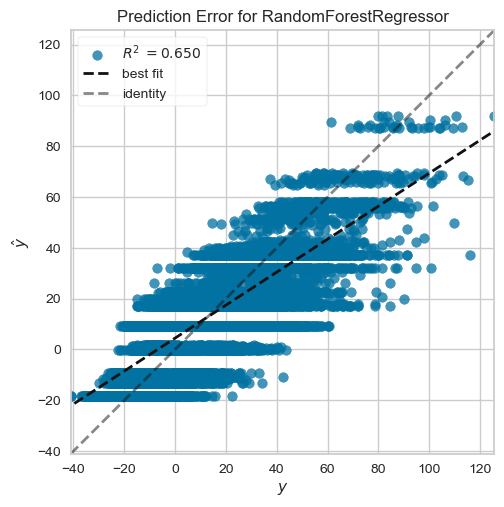

In [28]:
visualizer = prediction_error(model_rf, X_train, y_train, X_test, y_test)

Ao observar o gráfico de previsão de erro, podemos notar que existe uma certa variabilidade: os dados estão um pouco distantes da curva de ajuste (best fit), porém não muito distantes.
De certa forma, os dados estão concentrados na reta, o que indica que o modelo está prevendo bem os dados e não está errando muito.

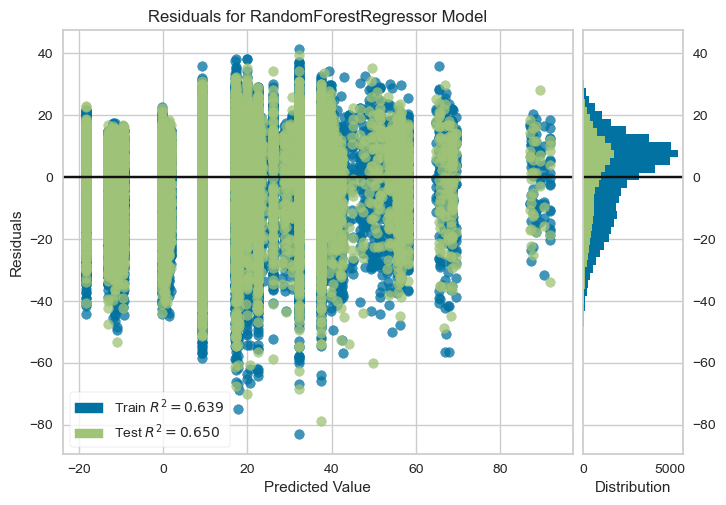

In [29]:
# Resíduo é o erro de previsão, o valor previsto menos o valor real.
visualizer = residuals_plot(model_rf, X_train, y_train, X_test, y_test)

Ao analisar o gráfico de resíduos, podemos notar que de certa forma os dados estão bem distribuídos em torno do valor 0 no gráfico a esquerda e o histograma está até bem próximo da distribuição normal, o que significa que o modelo está se adequando bem aos nossos dados.

#### Validação cruzada

E se os dados estiverem funcionando bem apenas para aquelas parcelas específicas de dados que dividimos? Para sanar essa dúvida, aplicamos o método Kfold e validação cruzada para verificar.

In [37]:
scoring = {
    'mae': 'neg_mean_absolute_error',
    'rmse': 'neg_root_mean_squared_error',
    'r2': 'r2'
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(model_rf, X_train, y_train, cv=cv, scoring=scoring)
cv_results

{'fit_time': array([3.0776701 , 2.82747173, 2.8923111 , 2.94911075, 2.87131858]),
 'score_time': array([0.06384706, 0.05785275, 0.06082535, 0.06586194, 0.06287313]),
 'test_mae': array([-11.07421449, -11.30328674, -11.05630068, -11.14454886,
        -11.17423931]),
 'test_rmse': array([-13.76668658, -14.04881475, -13.79310018, -13.87672957,
        -13.9303929 ]),
 'test_r2': array([0.64679676, 0.62433581, 0.64536956, 0.64090813, 0.63477298])}

In [36]:
for metric in scoring.keys():
    scores = cv_results[f'test_{metric}']
    mean_score = "{:.3f}".format(scores.mean())
    std_score = "{:.3f}".format(scores.std())

    print(f"{metric.upper()} Scores: {[f' {val:.3f}' for val in scores]}")
    print(f"{metric.upper()} Média: {mean_score}, Std: {std_score}")
    print('----------------------------------------------------------------------------------')


MAE Scores: [' -11.074', ' -11.303', ' -11.056', ' -11.145', ' -11.174']
MAE Média: -11.151, Std: 0.088
----------------------------------------------------------------------------------
RMSE Scores: [' -13.767', ' -14.049', ' -13.793', ' -13.877', ' -13.930']
RMSE Média: -13.883, Std: 0.101
----------------------------------------------------------------------------------
R2 Scores: [' 0.647', ' 0.624', ' 0.645', ' 0.641', ' 0.635']
R2 Média: 0.638, Std: 0.008
----------------------------------------------------------------------------------


Ao comparar os resultados das métricas obtidas anteriormente, podemos notar que os valores médias estão bem próximos, o que podemos concluir que o modelo está se ajustando bem para o conjunto de dados.